In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


In [3]:
## fetch data
mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

c:\Users\Acer\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape[0])

(70000, 784)
70000


6


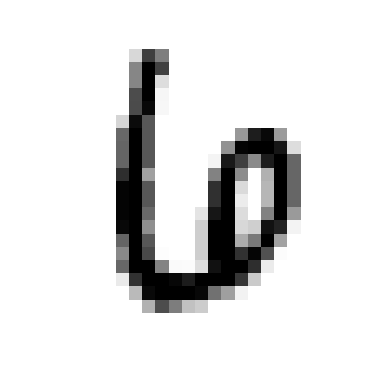

In [5]:
#checking out an image by selecting random rows
rand_val = np.random.randint(y.shape[0])
some_digit = X.loc[rand_val, :]

print(y[rand_val])

some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [6]:
### casting y from string to integers
y = y.astype(np.uint8)
y[rand_val]

6

#### splitting data

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary Classifier (trying a simple classification)

In [8]:
# creating a "5-detector"

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_test_5

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool

In [9]:
## trying a stochastic gradient descent (SGD)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(random_state=42)

In [10]:
print(y[rand_val])

6


In [11]:
sgd_clf.predict([some_digit])

c:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

#### measuring accuracy

In [12]:
# cross validation

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,  y_train_5, cv=3, scoring="accuracy")

## hence, this method (accuracy) is not the preferred performance measure for classifiers, especially when you are dealing with skewed dataset

array([0.91125, 0.90855, 0.90915])

#### confusion matrix

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # clean predictions

In [16]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [17]:
confusion_matrix(y_train_5, y_train_pred)

# [['true negatives',  'false positives'],
#  ['false negatives',  'true positive']]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# a perfect classifier  should look like this
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
# getting the precision and recall using data from the confusion metrix

precision_score(y_train_5, y_train_pred) # it claims to be correct in detecting 5s N% of the time (N is the value shown below)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # it only detects N%  of the 5s (N is the value shown below)

0.6511713705958311

In [21]:
# now combining the precision and recall, to get the F1 score ( harmonic mean )
f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### precision/recall trade-off

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-7693.17387217]
[False]


c:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [34]:
# deciding the best threshold value to use
y_scores =  cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds =  precision_recall_curve(y_train_5, y_scores)

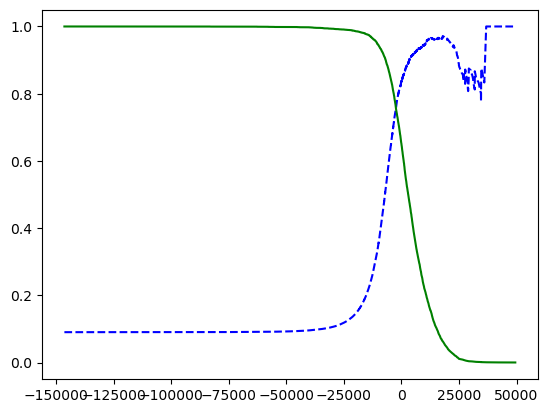

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis 

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

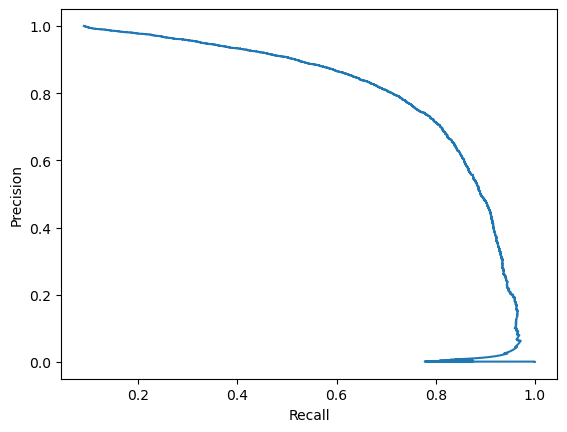

In [42]:
# ploting precisions against recalls, also another 
plt.plot(precisions, recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [45]:
# select 90% percent precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [49]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


##### ROC (receiver operating characteristics) curve

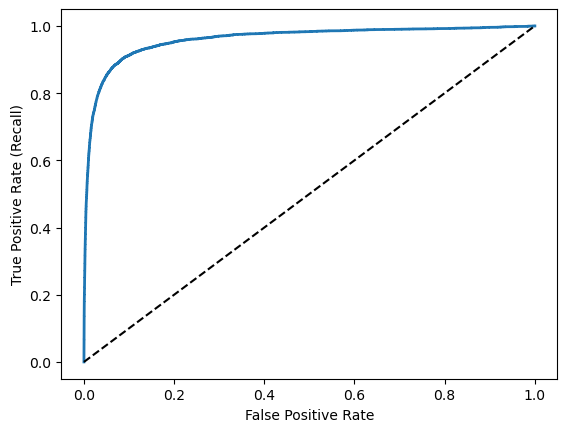

In [55]:
## 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [64]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### comparing ROC of RandomForestClassifier and SDGclassifier

In [59]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [60]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

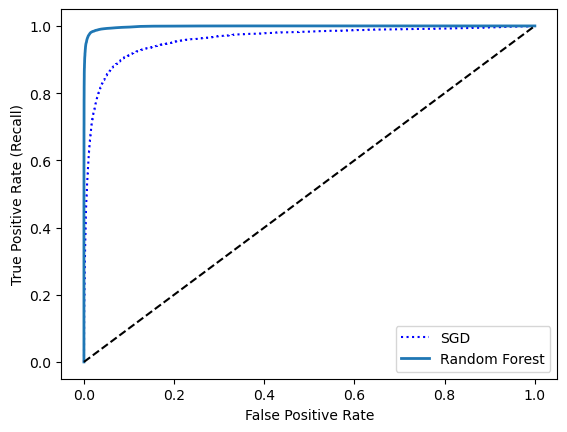

In [61]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [76]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [68]:
print(y[rand_val])

6


In [70]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [71]:
svm_clf.predict([some_digit])

c:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([6], dtype=uint8)

In [73]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# classes starting from 0, 1, 2 ... 9. where 5 shows high score, meaning there alot 5 images

c:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 7.22655905, -0.30503989,  6.24984826,  0.7063686 ,  8.29359542,
         1.73778972,  9.3097817 ,  5.10828648,  2.76403492,  3.78362501]])

In [75]:
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[0 1 2 3 4 5 6 7 8 9]
5
